In [1]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tf_slim
import tf_slim as slim


In [2]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.0 MB/s eta 0:00:00


In [3]:
import tensorflow_text as text

In [4]:
import pandas as pd
d1 = pd.read_csv("twitter_data.csv",encoding='unicode_escape')
d1.head(5)

,sentiment,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
d1.head(5)

,sentiment,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
def fun(text):
  if text=='Positive':
    return 1
  else:
    return 0

In [7]:
d1['final_sentiment']=d1['sentiment'].apply(fun)

In [8]:
d1.shape

(1165, 3)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d1['Tweet'],d1['final_sentiment'], stratify=d1['final_sentiment'])

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [12]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [14]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])


In [15]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [16]:
len(X_train)


873

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [18]:
model.fit(X_train, y_train, epochs=1,batch_size=100)

Epoch 1/10
9/9 [==============================] - 456s 49s/step - loss: 0.6824 - accuracy: 0.5590 - precision: 0.4560 - recall: 0.3911
Epoch 2/10
9/9 [==============================] - 441s 49s/step - loss: 0.6737 - accuracy: 0.5785 - precision: 0.4419 - recall: 0.1061
Epoch 3/10
9/9 [==============================] - 424s 47s/step - loss: 0.6496 - accuracy: 0.6117 - precision: 0.5364 - recall: 0.3911
Epoch 4/10
9/9 [==============================] - 428s 47s/step - loss: 0.6571 - accuracy: 0.6231 - precision: 0.6090 - recall: 0.2263
Epoch 5/10
9/9 [==============================] - 428s 47s/step - loss: 0.6366 - accuracy: 0.6380 - precision: 0.5981 - recall: 0.3575
Epoch 6/10
9/9 [==============================] - 430s 48s/step - loss: 0.6440 - accuracy: 0.6266 - precision: 0.5870 - recall: 0.3017
Epoch 7/10
9/9 [==============================] - 430s 48s/step - loss: 0.6330 - accuracy: 0.6495 - precision: 0.6413 - recall: 0.3296
Epoch 8/10
9/9 [==============================] - 431s 

In [20]:
model.evaluate(X_test, y_test)


10/10 [==============================] - 135s 13s/step - loss: 0.5996 - accuracy: 0.7055 - precision: 0.9250 - recall: 0.3083


[0.599648118019104, 0.7054794430732727, 0.925000011920929, 0.3083333373069763]

In [21]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()



10/10 [==============================] - 138s 14s/step


In [25]:
type(y_predicted)

numpy.ndarray

In [26]:
y_predicted=y_predicted.astype(int)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[172,   0],
       [120,   0]])

Text(50.722222222222214, 0.5, 'Truth')

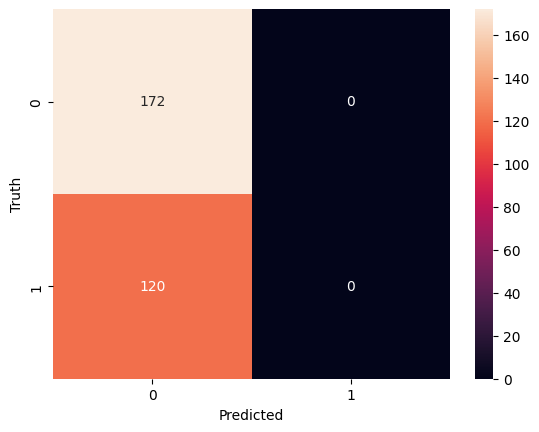

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


Sample Data

In [30]:
reviews = [
"on It'll be a beautiful game! Are you ready, RhandlerR? . . . . twitch.tv/weplayesport_en . .  ",
    '@ CSGO again I just qued alone and tuned with DMG and mg2 and am now gn3 and it was silver now wayyyy higher sorting the damn damn ranking system',

]
model.predict(reviews).astype(int)


1/1 [==============================] - 1s 1s/step


array([[0],
       [0]])